<a href="https://colab.research.google.com/github/Nil-123/Learn/blob/master/meep_lens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Colab Notebook to run FDTD simulations with meep

Author: Steffen Michaelis de Vasconcellos

## 0. Installation
First, we install CondaLab via pip to have the convenient Conda environment. It takes about 30-60 seconds. The session will send a message that it has crashed - this is normal. The environment is deleted each time you reconnect to Google Colab, so keep the runtime open.


In [22]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  try:
    import condacolab
    condacolab.check()
  except ImportError:
    !pip install -q condacolab
    import condacolab
    condacolab.install()


✨🍰✨ Everything looks OK!


Then we install meep via anaconda. We don't want to see the output therefore we use %%capture. Takes about 1 or 2 minutes.

In [23]:
%%capture
try:
  import meep as matplotlib
except ImportError:
  !conda install -c conda-forge pymeep

# Meep simulation

Now we can run a meep simulation. The meep documentation is found here: https://meep.readthedocs.io/en/latest/Python_User_Interface/

## 1. Import packages



In [24]:
import math
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

## 2. Define constants
Define some physical constants of the simulation (e.g. refractive index, wavelength) and some parameters of the FDTD simulation (e.g. resolution, size of the simulation grid)

Most important: Defines the parameters of the elliptical lens and the polarization of the dipole source. Here you can change things!

In [25]:
#refractive indieces
index_lens = 1.52
index_substrate = 2.4
index_air = 1
#index_hBN = 2.2


#define lens parameters
lens_a = 20
lens_b = 20
lens_h = lens_b
#lens_b = lens_a*index_lens/(index_lens**2-index_air**2)**(1/2)
#lens_h = lens_a*((index_lens+index_air)/(index_lens-index_air))**(1/2)
lens_offset = 0
lens_offset_x = 0

#source polarization "s" or "p" or "z" or "45°"
source_direction = "p"
source_dep=2   #below substrate

#wavelength in um
wavelength = 0.637

print('Lens parameters:')
print('Lens short axis (a):', lens_a)
print('Lens long axis (b):', lens_b)
print('Lens height (h):', lens_h)
print('Lens offset (y):', lens_offset)
print('Lens offset (x):', lens_offset_x)




## Calculate and define some further constants for the simulation - don't edit unless you know what you are doing

#frequency
fcen = 1/wavelength

#resolution
resolution = 16     #pixel/um

hBN_height = 2/resolution #center of the dipole emitter, 1 grid point above the substrate surface

#resolution is set via parameters alternative here:
#resolution_per_wavelength = 8
#resolution = int(np.floor(resolution_per_wavelength*fcen*index_lens))  # pixels/um
print("Resolution", resolution)
print("hBn height", hBN_height)
dpml = 1

#defince simulation cell size. size_x and y are parameters multiplies with lens size
size_y = 8
size_x = 8
sx = np.floor(size_x*(lens_a))+1  #size of simulation area
sy = np.floor(size_y*(lens_a))+1
print(f"Sx = {sx}")
print(f"Sy = {sy}")
substrate_height = sy/2 + dpml #- extra_space
substrate_x = sx + 2*dpml #- extra_space
print(f"Substrate_height = {substrate_height}")
print(f"Substrate_x = {substrate_x}")

Lens parameters:
Lens short axis (a): 20
Lens long axis (b): 20
Lens height (h): 20
Lens offset (y): 0
Lens offset (x): 0
Resolution 16
hBn height 0.125
Sx = 161.0
Sy = 161.0
Substrate_height = 81.5
Substrate_x = 163.0


## 3. Define the geometry in meep
Here an ellipsoid is chosen for the lens. You could modify that part by using a different geomerty class (see meep documentation), but initally it is better to modify only parameters in the cell above.

In [26]:
#define geometry
geometry = []
"""
#lens
geometry.append(
    mp.Ellipsoid(
      center=mp.Vector3(lens_offset_x,lens_b-lens_h-lens_offset,0),
      size=mp.Vector3(2*lens_a,2*lens_b,2*lens_b),
      e1=mp.Vector3(1,0,0), e2=mp.Vector3(0,1,0), e3=mp.Vector3(0,0,1),
      material=mp.Medium(index=index_lens)))
"""
#substrate

geometry.append(
    mp.Block(
        size=mp.Vector3(substrate_x, substrate_height, 0),
        center=mp.Vector3(0,substrate_height/2,0),
        material=mp.Medium(index=index_substrate)))




## 4. Define the dipole source in meep
Don't edit here.

In [27]:
if source_direction == "p":
    print("Source direction Ex")
    src_cmpt = mp.Ex
elif source_direction == "s":
    print("Source direction Ez")
    src_cmpt = mp.Ez
elif source_direction == "z":
    print("Source direction perpendicular to surface (Ey)")
    src_cmpt = mp.Ey

sources = [mp.Source(src=mp.ContinuousSource(fcen),
                     center=mp.Vector3(0,source_dep,0),
                     component=src_cmpt)]     #-hBN_height/2

Source direction Ex


## 5. Setup the simulation
Don't edit here. Running this cell resets also the simulation.

In [28]:
#calculate cell
print(f"Cell X {sx+2*dpml} Cell Y {sy+2*dpml}")
cell = mp.Vector3(sx+2*dpml,sy+2*dpml)  #size of computation cell

#make PML
pml_layers = [mp.PML(dpml)]

#add symmetries
#in a 2D simulation (optical axis in Y direction), we have only symmetires in X direction. This can be either inverted (phase=-1) or normal.
if src_cmpt == mp.Ex:
    symmetries = [mp.Mirror(mp.X,phase=-1)]
elif src_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X,phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X,phase=+1)]

if lens_offset_x != 0:
  symmetries = []

#make simulation
sim = mp.Simulation(cell_size=cell,
                    resolution=resolution,
                    sources=sources,
                    geometry=geometry,
                    symmetries=symmetries,
                    boundary_layers=pml_layers,
                    force_complex_fields=False)

# Add a flux monitor **above the substrate**
flux_y =-50 # (sy/2 - dpml/2) #sy / 2 -dpml -1  # y-position of the flux monitor
print(f"Flux monitor y {flux_y}")
flux_monitor = sim.add_flux(fcen, 0, 1,
                            mp.FluxRegion(center=mp.Vector3(0, flux_y, 0),
                                          size=mp.Vector3(sx, 0, 0)))



Cell X 163.0 Cell Y 163.0
Flux monitor y -50


## 6. Run the simulation
Running for a certain amount of timesteps (e.g. 100). You can run this cell multiple times to continoue the simulation. `until` means that that number of step is added to the simulation. The number of timesteps required that the light propagates through the whole cell depends on the size of the cell and the resolution

In [29]:
run_until = 500
sim.run(until=run_until)

flux_no_sil = mp.get_fluxes(flux_monitor)
print(f"Flux no sil {flux_no_sil}")

-----------
Initializing structure...
Halving computational cell along direction x
time for choose_chunkdivision = 0.00206304 s
Working in 2D dimensions.
Computational cell is 163 x 163 x 0 with resolution 16
     block, center = (0,40.75,0)
          size (163,81.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
time for set_epsilon = 8.27944 s
-----------


FloatProgress(value=0.0, description='0% done ')

Meep progress: 7.53125/100.0 = 7.5% done in 4.0s, 49.3s to go
on time step 241 (time=7.53125), 0.0166539 s/step
Meep progress: 15.90625/100.0 = 15.9% done in 8.0s, 42.4s to go
on time step 509 (time=15.9062), 0.0149474 s/step
Meep progress: 24.34375/100.0 = 24.3% done in 12.0s, 37.4s to go
on time step 779 (time=24.3438), 0.0148781 s/step
Meep progress: 32.5625/100.0 = 32.6% done in 16.0s, 33.2s to go
on time step 1042 (time=32.5625), 0.0152387 s/step
Meep progress: 40.78125/100.0 = 40.8% done in 20.1s, 29.1s to go
on time step 1305 (time=40.7812), 0.0152205 s/step
Meep progress: 48.5625/100.0 = 48.6% done in 24.1s, 25.5s to go
on time step 1554 (time=48.5625), 0.0160723 s/step
Meep progress: 56.6875/100.0 = 56.7% done in 28.1s, 21.4s to go
on time step 1814 (time=56.6875), 0.0154109 s/step
Meep progress: 64.90625/100.0 = 64.9% done in 32.1s, 17.3s to go
on time step 2077 (time=64.9062), 0.015229 s/step
Meep progress: 72.8125/100.0 = 72.8% done in 36.1s, 13.5s to go
on time step 2330 (

## 7. Analyze

After running the simulation, we can analyze the output. Here we plot the total power of the electric field overlayed with epsilon.

Edit vmax if the color scale is not appropriate.

You can also plot other parameters, e.g. the electric field. Try uncommenting the lines.

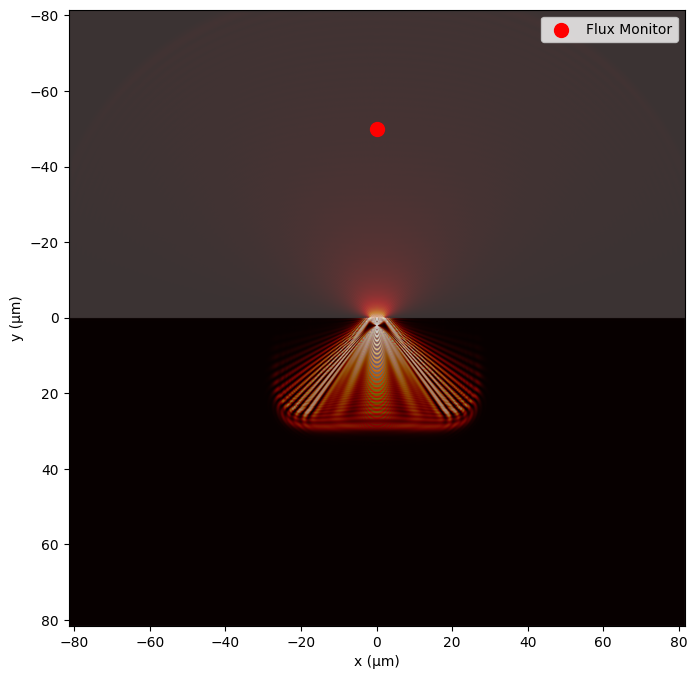

In [30]:
# Define the physical extent of the simulation cell:
cell = sim.cell_size  # e.g., cell.x and cell.y for 2D
extent = [-cell.x/2, cell.x/2, -cell.y/2, cell.y/2]

eps_data = sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=mp.Dielectric).transpose()
efield_data = sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=src_cmpt).transpose()
tot_pwr = sim.get_tot_pwr().transpose()
plt.figure(figsize=(10,8))
plt.imshow(eps_data,extent=extent, origin='lower', interpolation='spline36', cmap='binary')
plt.xlabel("x (μm)")
plt.ylabel("y (μm)")
# Get the flux monitor center (assuming it was defined as a FluxRegion):
flux_center = flux_monitor.regions[0].center  # mp.Vector3 object
# Mark the flux monitor with a red dot:

#plt.axis('off')
#plt.show()
#plt.figure(figsize=(10,8))
plt.imshow(tot_pwr, extent=extent, origin='lower', interpolation='spline36', cmap='hot', vmin=0,vmax=.1,alpha=0.8)
#plt.axis('off')
#plt.show()
#plt.figure(figsize=(10,8))
#plt.imshow(efield_data, interpolation='spline36', cmap='RdBu', vmin=-.2,vmax=.2,alpha=0.8)
#plt.axis('off')
plt.scatter(flux_center.x, flux_center.y, color='red', marker='o', s=100, label="Flux Monitor")
plt.gca().invert_yaxis()  # Inverts the y-axis
plt.legend()
plt.show()


Source direction Ex
Cell X 163.0 Cell Y 163.0
Flux monitor y -50
-----------
Initializing structure...
Halving computational cell along direction x
time for choose_chunkdivision = 0.00193095 s
Working in 2D dimensions.
Computational cell is 163 x 163 x 0 with resolution 16
     ellipsoid, center = (0,0,0)
          size (40,40,40)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.3104,2.3104,2.3104)
     block, center = (0,40.75,0)
          size (163,81.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
time for set_epsilon = 6.15162 s
-----------


FloatProgress(value=0.0, description='0% done ')

Meep progress: 5.90625/100.0 = 5.9% done in 4.0s, 64.1s to go
on time step 189 (time=5.90625), 0.0212702 s/step
Meep progress: 11.71875/100.0 = 11.7% done in 8.0s, 60.6s to go
on time step 375 (time=11.7188), 0.0215919 s/step
Meep progress: 17.84375/100.0 = 17.8% done in 12.1s, 55.5s to go
on time step 571 (time=17.8438), 0.0204457 s/step
Meep progress: 23.5625/100.0 = 23.6% done in 16.1s, 52.1s to go
on time step 754 (time=23.5625), 0.0219426 s/step
Meep progress: 29.59375/100.0 = 29.6% done in 20.1s, 47.8s to go
on time step 947 (time=29.5938), 0.0207312 s/step
Meep progress: 35.84375/100.0 = 35.8% done in 24.1s, 43.1s to go
on time step 1147 (time=35.8438), 0.0200031 s/step
Meep progress: 41.5625/100.0 = 41.6% done in 28.1s, 39.5s to go
on time step 1330 (time=41.5625), 0.021925 s/step
Meep progress: 47.71875/100.0 = 47.7% done in 32.1s, 35.2s to go
on time step 1527 (time=47.7188), 0.0203054 s/step
Meep progress: 53.90625/100.0 = 53.9% done in 36.1s, 30.9s to go
on time step 1725 (

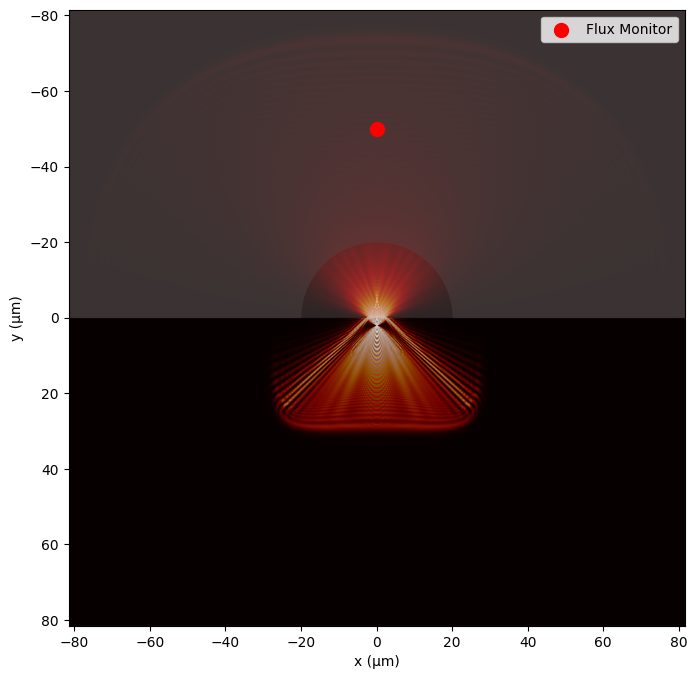

In [31]:
sim.reset_meep()
#define geometry
geometry = []

#lens
geometry.append(
    mp.Ellipsoid(
      center=mp.Vector3(lens_offset_x,lens_b-lens_h-lens_offset,0),
      size=mp.Vector3(2*lens_a,2*lens_b,2*lens_b),
      e1=mp.Vector3(1,0,0), e2=mp.Vector3(0,1,0), e3=mp.Vector3(0,0,1),
      material=mp.Medium(index=index_lens)))

#substrate

geometry.append(
    mp.Block(
        size=mp.Vector3(substrate_x, substrate_height, 0),
        center=mp.Vector3(0,substrate_height/2,0),
        material=mp.Medium(index=index_substrate)))

if source_direction == "p":
    print("Source direction Ex")
    src_cmpt = mp.Ex
elif source_direction == "s":
    print("Source direction Ez")
    src_cmpt = mp.Ez
elif source_direction == "z":
    print("Source direction perpendicular to surface (Ey)")
    src_cmpt = mp.Ey

sources = [mp.Source(src=mp.ContinuousSource(fcen),
                     center=mp.Vector3(0,source_dep,0),
                     component=src_cmpt)]     #-hBN_height/2

#calculate cell
print(f"Cell X {sx+2*dpml} Cell Y {sy+2*dpml}")
cell = mp.Vector3(sx+2*dpml,sy+2*dpml)  #size of computation cell

#make PML
pml_layers = [mp.PML(dpml)]

#add symmetries
#in a 2D simulation (optical axis in Y direction), we have only symmetires in X direction. This can be either inverted (phase=-1) or normal.
if src_cmpt == mp.Ex:
    symmetries = [mp.Mirror(mp.X,phase=-1)]
elif src_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X,phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X,phase=+1)]

if lens_offset_x != 0:
  symmetries = []

#make simulation
sim = mp.Simulation(cell_size=cell,
                    resolution=resolution,
                    sources=sources,
                    geometry=geometry,
                    symmetries=symmetries,
                    boundary_layers=pml_layers,
                    force_complex_fields=False)

# Add a flux monitor **above the substrate**
flux_y =-50 # (sy/2 - dpml/2) #sy / 2 -dpml -1  # y-position of the flux monitor
print(f"Flux monitor y {flux_y}")
flux_monitor = sim.add_flux(fcen, 0, 1,
                            mp.FluxRegion(center=mp.Vector3(0, flux_y, 0),
                                          size=mp.Vector3(sx, 0, 0)))


sim.run(until=run_until)

flux_with_sil = mp.get_fluxes(flux_monitor)
print(f"Flux with sil {flux_with_sil}")
# Define the physical extent of the simulation cell:
cell = sim.cell_size  # e.g., cell.x and cell.y for 2D
extent = [-cell.x/2, cell.x/2, -cell.y/2, cell.y/2]

eps_data = sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=mp.Dielectric).transpose()
efield_data = sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=src_cmpt).transpose()
tot_pwr = sim.get_tot_pwr().transpose()
plt.figure(figsize=(10,8))
plt.imshow(eps_data,extent=extent, origin='lower', interpolation='spline36', cmap='binary')
plt.xlabel("x (μm)")
plt.ylabel("y (μm)")
# Get the flux monitor center (assuming it was defined as a FluxRegion):
flux_center = flux_monitor.regions[0].center  # mp.Vector3 object
# Mark the flux monitor with a red dot:

#plt.axis('off')
#plt.show()
#plt.figure(figsize=(10,8))
plt.imshow(tot_pwr, extent=extent, origin='lower', interpolation='spline36', cmap='hot', vmin=0,vmax=.1,alpha=0.8)
#plt.axis('off')
#plt.show()
#plt.figure(figsize=(10,8))
#plt.imshow(efield_data, interpolation='spline36', cmap='RdBu', vmin=-.2,vmax=.2,alpha=0.8)
#plt.axis('off')
plt.scatter(flux_center.x, flux_center.y, color='red', marker='o', s=100, label="Flux Monitor")
plt.gca().invert_yaxis()  # Inverts the y-axis
plt.legend()
plt.show()




Vector3<0.0, -50.0, 0.0>